Import Libraries

In [66]:
# ensures that matplotlib plots are disdplayed inside the notebook 
%matplotlib inline

# provides access to system-specific parameters and functions
import sys
# helps with file and directory operations, enviornment variables, and process control
import os
# for image loading, processing, and manipulation
import cv2
import shutil

import matplotlib # for plotting and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d # for creating 3D plots
from tqdm import tqdm # library used for displaying progress bars for loops
from sklearn.model_selection import train_test_split


import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random 
print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))
print("tensorflow: {}".format(tf.__version__))
print("current working directory:", os.getcwd()) # prints curr working directory
print("list of files:", os.listdir())  # Lists the files in the current directory
print("cv2 version:", cv2.__version__)
print("tensorflow: {}".format(tf.__version__))

# Load image
import imageio

# automatically reloads modules before executing code
%load_ext autoreload
%autoreload 2

Version information
python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
matplotlib: 3.9.2
numpy: 1.26.4
tensorflow: 2.10.1
current working directory: c:\Users\wiito\Documents\Github\Alzheimer-Detection\notebooks
list of files: ['1_CNN.ipynb', '2_Model_2.ipynb', '3_Model_3.ipynb', 'preprocessing.py']
cv2 version: 4.10.0
tensorflow: 2.10.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
DATASET_PATH = "../Data/"
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.3
IMAGE_SIZE = (496, 248)
data_dir = pathlib.Path(DATASET_PATH)


Checking for corrupt images

In [25]:
from PIL import Image
import os

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.load()  # Load image to detect issues
            except Exception as e:
                print(f"Corrupted image detected: {os.path.join(root, file)} - {e}")

directory setup and split data

In [ ]:
print(data_dir)
print(data_dir.exists())

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        labels="inferred",
        directory=data_dir,
        batch_size=None,
        validation_split=VALIDATION_SPLIT,
        seed=0,
        image_size=IMAGE_SIZE,
        subset='both')
test_ds = val_ds.shard(num_shards=3, index=0).concatenate(
               val_ds.shard(num_shards=3, index=1))
val_ds = val_ds.shard(num_shards=3, index=2)

train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=500)
val_ds = val_ds.shuffle(buffer_size=500)
# train = 0.8 test = 0.1 val = 0.1
print("data has been split")

../Data
True
Found 86437 files belonging to 4 classes.
Using 69150 files for training.
Using 17287 files for validation.
data has been split


preprocessing data -- data augmentation & normalization

In [ ]:
IMG_SIZE = 176 # resize images to 176 x 176
BRIGHT_RANGE = [0.8, 1.2] # adjust brightness to 80 - 120% of original
ZOOM = [0.99, 1.01] # range of zoom -- 1% in or out
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

# imagedatagenerators
# rescale: normalizes pixel values by dividing by 255 --> bring values in range [0, 1]
# brightness_range: randomly adjusts brightness within specified range 
# zoom_range: randomly zoomes in/out within specifed range
# horizontal_flip: randomly flips images horizontally for more variety
# want augmentation in training data but not test/validation --> just rescale
train_image_generator = ImageDataGenerator(rescale = 1./255, brightness_range = BRIGHT_RANGE, zoom_range = ZOOM, data_format = DATA_FORMAT, fill_mode = FILL_MODE, horizontal_flip = True)

validation_image_generator = ImageDataGenerator(rescale = 1./255)

test_image_generator = ImageDataGenerator(rescale = 1./255)

# each batch has 32 images
print("train images - 70%")
train_dataset = train_image_generator.flow_from_directory(batch_size = 32, directory = os.path.join(split_dir, 'train'), target_size = (176, 176), shuffle = True)

print("test images - 20%")
test_dataset = test_image_generator.flow_from_directory(batch_size = 32, directory = os.path.join(split_dir, 'test'), target_size = (176, 176), shuffle = False)

print("validation images - 10%")
validation_dataset = validation_image_generator.flow_from_directory(batch_size = 32, directory = os.path.join(split_dir, 'validation'), target_size = (176, 176), shuffle = False)


Visualize batch of images from dataset 

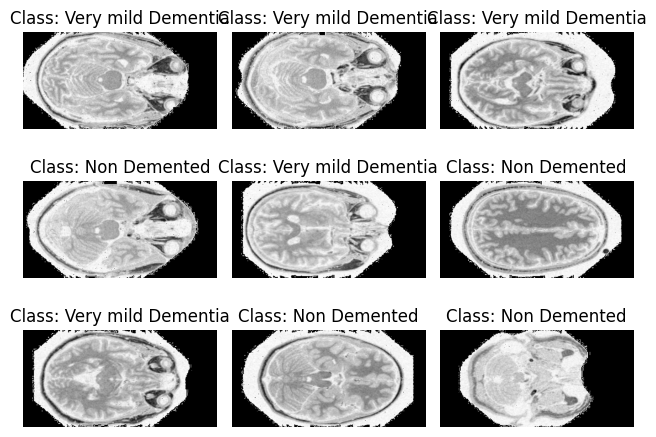

In [65]:
def image_sample_visualization(dataset, y_pred = None):
    labels = dict(zip([0, 1, 2, 3], classes))
    dataset = dataset.shuffle(buffer_size=10)
    iterator = dataset.as_numpy_iterator()
    # get batch of images and labels
    images = [iterator.next() for i in range(9)]
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img, label = images[i]


        img = (img * 255).astype(np.uint8)

        # show image
        plt.imshow(img)
        plt.axis("off")
        plt.title("Class: {}".format(labels[label]))

    plt.tight_layout()
    plt.show()
image_sample_visualization(test_ds)

In [ ]:
def image_sample_visualization(generator, y_pred = None):
    labels = dict(zip([0, 1, 2, 3], classes))

    # get batch of images and labels
    x, y = generator.next()

    # display grid of 9 images
    plt.figure(figsize = (10, 10))
    if y_pred is None:
        # display actually class labels for 9 random iamges
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            index = random.randint(0, len(x) - 1) #randomly select an index within the batch size
            img = x[index]

            # rescale image for display if needed
            if img.max() <= 1:
                img = (img * 255).astype(np.uint8)

            # show image
            plt.imshow(img)
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[index])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = x[i]

            # rescale image for display if needed
            if img.max() <= 1:
                img = (img * 255).astype(np.uint8)

            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))

    plt.tight_layout()
    plt.show()

image_sample_visualization(train_dataset)

# Actual model?